# The Battle for Neighborhood (week 02)

TABLE OF CONTENT:

1. Introduction: Discuss the buisness problem and get familiar to the project.
2. Data Selection: Description of valuable data resources to be used to complete the project.
3. Methodology: Application of data cleaning, sorting, analysis, applying machine learning algorithms, data taining & testing in order to establish the purpose to reach the target.
4. Result: Get familiar to the results or output
5. Discussion: Explaination of the results and discuss the outcome.
6. Conclusion: Finalize report


## Question 1: A full report consisting of all of the following components (15 marks):
a) Introduction where you discuss the business problem and who would be interested in this project.

b) Data where you describe the data that will be used to solve the problem and the source of the data.

c) Methodology section which represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, if any, and what machine learnings were used and why.

d) Results section where you discuss the results.

e) Discussion section where you discuss any observations you noted and any recommendations you can make based on the results.

f) Conclusion section where you conclude the report.

## 1. Introduction: 
This project is regarding the comparison of neighborhoods of two cities namely "Manhattan NY" and "Toronto" in choosing the best place to live provided all the necessary ammenities around.

The basic idea behind this comparison is that I have got new job offers as a data scientist in "Manhattan NY" and another in "Toronto". There are some basic evaluation criteria which I would like to check by means of this project in searching for apartment and living standards in the two cities. Follwing are the basic queries to be addressed:

1. Two bedroom or three bedroom apartment.
2. Metro station must be 1 mile from the place of living.
3. Rent not more than $10000.
4. Top ammenities must be included in both places.
5. Resturants, groceries stores, wine shop are desirable nearby.

### Problems:
The difficult part is to locate a suitable apartment for rent in both places "Manhattan NY" and "Toronto" that fulfil the demands of price, location and ammenities. In the following section 2 I will explain the process of data collection and importance while addressing the issues. 

### Import basic libraries required for this project

In [109]:
import numpy as np 
import time
import pandas as pd 
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

import json 
import requests 
from pandas.io.json import json_normalize 

from geopy.geocoders import Nominatim 
import geopy
import folium 
from folium import plugins

import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


In [110]:
# A description of the data and how it will be used to solve the problem. (15 marks)

## 2. Data formulation:

### Following data are required for the project
1. List of Boroughs and neighborhoods of Manhattan and Toronto with their geodata (Latitude and Longitude).
2. List of subways metro stations with their address location.
3. List of apartment for rent in Manhattan and Toronto.
4. Desired additional information about the price, number of beds etc.
5. Venues for each neighborhoods in Manhattan and Toronto.
6. Venues for subway metro stations.

### How to solve problem using above data?
We will use the data in follwing way:
1. Use Foursqure and geopy data to sort the top 10 venues in "Toronto" and "Manhattan" neighborhood and cluster them in group. Then locate the subway stations seperately and layer it over the created cluster group.
2. Again use the same geopy and foursqure data to map the location of rental places. 
3. Filter the data with the average rental price $1000 per month and radius of 1 mile near the subway station. 
4. Convert the address of the rental location to latitude and logitute.



### METHODOLOGY : Data Mapping


In [111]:
address1 = "Mill Street, Toronto"
geolocator = Nominatim(user_agent = "my-application")
location = geolocator.geocode(address1)
latitude = location.latitude
longitude = location.longitude
#geopy.geocoders.options.default_user_agent = "my-application"
print('Geogrophical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

Geogrophical coordinates of Toronto are 43.6520276, -79.3545845.


In [112]:
address2 = "New York, NY"
geolocator = Nominatim(user_agent = "my-application")
location = geolocator.geocode(address2)
latitude = location.latitude
longitude = location.longitude
#geopy.geocoders.options.default_user_agent = "my-application"
print('Geogrophical coordinates of Manhattan NY are {}, {}.'.format(latitude, longitude))

Geogrophical coordinates of Manhattan NY are 40.7127281, -74.0060152.


In [113]:
toronto_latitude=43.6520276
toronto_longitude=-79.3545845
ny_latitude=40.7127281
ny_longitude=-74.0060152

In [114]:
# @hidden cell
CLIENT_ID = 'xx'
CLIENT_SECRET = 'xx'
VERSION = '20180605'

In [115]:
LIMIT = 200 # number of venues returned by Foursquare API
radius = 500 # radius

# create URL
url1 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    toronto_latitude, 
    toronto_longitude, 
    radius, 
    LIMIT)
url1    # url is commented 

'https://api.foursquare.com/v2/venues/explore?&client_id=NBIH1DS3BZN0IW0HAJTCRK4JZJ2MBBHHHNM5T4FQ4WHOWOCL&client_secret=W4VG2CYODHARJICTSWBPROOZ5RSS5YSSSEC55SJJ1JXP4G5F&v=20180605&ll=43.6520276,-79.3545845&radius=500&limit=200'

In [116]:
# create URL
url2 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    ny_latitude, 
    ny_longitude, 
    radius, 
    LIMIT)
url2    # url is commented 

'https://api.foursquare.com/v2/venues/explore?&client_id=NBIH1DS3BZN0IW0HAJTCRK4JZJ2MBBHHHNM5T4FQ4WHOWOCL&client_secret=W4VG2CYODHARJICTSWBPROOZ5RSS5YSSSEC55SJJ1JXP4G5F&v=20180605&ll=40.7127281,-74.0060152&radius=500&limit=200'

In [117]:
get_json1 = requests.get(url1).json()
with open('toronto.json', 'w') as json_file:
    json.dump(get_json1, json_file)
# Get json file

In [118]:
get_json2 = requests.get(url2).json()
with open('ny.json', 'w') as json_file:
    json.dump(get_json2, json_file)
# Get json file

In [119]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [120]:
venues_toronto = get_json1['response']['groups'][0]['items']
    
SGnearby_venues_toronto = json_normalize(venues_toronto) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
SGnearby_venues_toronto =SGnearby_venues_toronto.loc[:, filtered_columns]

# filter the category for each row
SGnearby_venues_toronto['venue.categories'] = SGnearby_venues_toronto.apply(get_category_type, axis=1)

# clean columns
SGnearby_venues_toronto.columns = [col.split(".")[-1] for col in SGnearby_venues_toronto.columns]

SGnearby_venues_toronto.head(10)

,name,categories,lat,lng
0,Souk Tabule,Mediterranean Restaurant,43.653756,-79.354390
1,Young Centre for the Performing Arts,Performing Arts Venue,43.650825,-79.357593
2,Sukhothai,Thai Restaurant,43.653701,-79.354447
3,SOMA chocolatemaker,Chocolate Shop,43.650622,-79.358127
4,Toronto Cooper Koo Family Cherry St YMCA Centre,Gym / Fitness Center,43.653191,-79.357947
5,Cluny Bistro & Boulangerie,French Restaurant,43.650565,-79.357843
6,The Distillery Historic District,Historic Site,43.650244,-79.359323
7,Underpass Park,Park,43.655764,-79.354806
8,Balzac's Coffee,Coffee Shop,43.649797,-79.359142
9,Corktown Common,Park,43.655618,-79.356211


In [121]:
venues_ny = get_json2['response']['groups'][0]['items']
    
SGnearby_venues_ny = json_normalize(venues_ny) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
SGnearby_venues_ny =SGnearby_venues_ny.loc[:, filtered_columns]

# filter the category for each row
SGnearby_venues_ny['venue.categories'] = SGnearby_venues_ny.apply(get_category_type, axis=1)

# clean columns
SGnearby_venues_ny.columns = [col.split(".")[-1] for col in SGnearby_venues_ny.columns]

SGnearby_venues_ny.head(10)
#SGnearby_venues_ny.shape

,name,categories,lat,lng
0,The Bar Room at Temple Court,Hotel Bar,40.711448,-74.006802
1,The Beekman - A Thompson Hotel,Hotel,40.711173,-74.006702
2,City Hall Park,Park,40.712415,-74.006724
3,Alba Dry Cleaner & Tailor,Laundry Service,40.711434,-74.006272
4,The Wooly Daily,Coffee Shop,40.712137,-74.008395
5,Gibney Dance Center Downtown,Dance Studio,40.713923,-74.005661
6,Augustine,French Restaurant,40.711310,-74.006660
7,The Class by Taryn Toomey,Gym / Fitness Center,40.712753,-74.008734
8,Takahachi Bakery,Bakery,40.713653,-74.008804
9,Aahar Indian Cuisine,Indian Restaurant,40.713307,-74.007994


In [122]:
# Toronto Map with latitude and longitude values
map_sg_toronto = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=15)

# add markers to map
for lat, lng, label_toronto in zip(SGnearby_venues_toronto['lat'], SGnearby_venues_toronto['lng'], SGnearby_venues_toronto['name']):
    label_toronto = folium.Popup(label_toronto, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=3,
        radius=8,
        popup=label_toronto,
        color='orange',
        fill_color='#0f0f0f',
        fill_opacity=0.6,
    ).add_to(map_sg_toronto)  
    
map_sg_toronto

In [123]:
# Manhattan NY Map with latitude and longitude values
map_sg_ny = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=15)

# add markers to map
for lat, lng, label_ny in zip(SGnearby_venues_ny['lat'], SGnearby_venues_ny['lng'], SGnearby_venues_ny['name']):
    label_ny = folium.Popup(label_ny, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label_ny,
        color='red',
        fill_color='#0f0f0f',
        fill_opacity=0.6,
    ).add_to(map_sg_ny)  
    
map_sg_ny

In [124]:
# Read csv file of clustered neighborhoods in Manhattan NY
ny_data  = pd.read_csv('ny_neigh.csv') 
#ny_data.head()

In [125]:
ny_complete = pd.read_csv('complete_ny.csv')
ny_complete.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,2,Coffee Shop,Discount Store,Yoga Studio,Steakhouse,Supplement Shop,Tennis Stadium,Shoe Store,Gym,Bank,Seafood Restaurant
1,Manhattan,Chinatown,40.715618,-73.994279,2,Chinese Restaurant,Cocktail Bar,Dim Sum Restaurant,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Noodle House,Bakery,Bubble Tea Shop,Ice Cream Shop
2,Manhattan,Washington Heights,40.851903,-73.936900,4,Café,Bakery,Mobile Phone Shop,Pizza Place,Sandwich Place,Park,Gym,Latin American Restaurant,Tapas Restaurant,Mexican Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,3,Mexican Restaurant,Lounge,Pizza Place,Café,Wine Bar,Bakery,American Restaurant,Park,Frozen Yogurt Shop,Spanish Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0,Mexican Restaurant,Coffee Shop,Café,Deli / Bodega,Pizza Place,Liquor Store,Indian Restaurant,Sushi Restaurant,Sandwich Place,Yoga Studio


In [126]:
# create map of Manhattan using latitude and longitude values from Nominatim
ny_lat = 40.7308619
ny_long = -73.9871558 

k_cluster=5
map_clusters = folium.Map(location=[ny_lat, ny_long], zoom_start=13)

# set color scheme for the clusters
x = np.arange(k_cluster)
ys = [i+x+(i*x)**2 for i in range(k_cluster)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_complete['Latitude'], ny_complete['Longitude'], ny_complete['Neighborhood'], ny_complete['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
  # add markers for rental places to map
for lat, lng, label in zip(ny_data['Latitude'], ny_data['Longitude'], ny_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)    
    
       
map_clusters

## The cluster data shows that 4rth cluster is best suited place to live

In [127]:
nk = 2
ny_complete.loc[ny_complete['Cluster Labels'] == nk, ny_complete.columns[[1] + list(range(5, ny_complete.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Coffee Shop,Discount Store,Yoga Studio,Steakhouse,Supplement Shop,Tennis Stadium,Shoe Store,Gym,Bank,Seafood Restaurant
1,Chinatown,Chinese Restaurant,Cocktail Bar,Dim Sum Restaurant,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Noodle House,Bakery,Bubble Tea Shop,Ice Cream Shop
6,Central Harlem,African Restaurant,Seafood Restaurant,French Restaurant,American Restaurant,Cosmetics Shop,Chinese Restaurant,Event Space,Liquor Store,Beer Bar,Gym / Fitness Center
9,Yorkville,Coffee Shop,Gym,Bar,Italian Restaurant,Sushi Restaurant,Pizza Place,Mexican Restaurant,Deli / Bodega,Japanese Restaurant,Pub
14,Clinton,Theater,Italian Restaurant,Coffee Shop,American Restaurant,Gym / Fitness Center,Hotel,Wine Shop,Spa,Gym,Indie Theater
23,Soho,Clothing Store,Boutique,Women's Store,Shoe Store,Men's Store,Furniture / Home Store,Italian Restaurant,Mediterranean Restaurant,Art Gallery,Design Studio
26,Morningside Heights,Coffee Shop,American Restaurant,Park,Bookstore,Pizza Place,Sandwich Place,Burger Joint,Café,Deli / Bodega,Tennis Court
34,Sutton Place,Gym / Fitness Center,Italian Restaurant,Furniture / Home Store,Indian Restaurant,Dessert Shop,American Restaurant,Bakery,Juice Bar,Boutique,Sushi Restaurant
39,Hudson Yards,Coffee Shop,Italian Restaurant,Hotel,Theater,American Restaurant,Café,Gym / Fitness Center,Thai Restaurant,Restaurant,Gym


### Rental classification using the NY.csv stored file

In [128]:
ny_rent=pd.read_csv('ny_rent.csv')
ny_rent.head()

,Address,Area,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long
0,West 105th Street,Upper West Side,2.94,5.0,3400,10000,40.799771,-73.966213
1,East 97th Street,Upper East Side,3.57,3.0,2100,7500,40.788585,-73.955277
2,West 105th Street,Upper West Side,1.89,4.0,2800,5300,40.799771,-73.966213
3,CARMINE ST.,West Village,3.03,2.0,1650,5000,40.730523,-74.001873
4,171 W 23RD ST.,Chelsea,3.45,2.0,1450,5000,40.744118,-73.995299


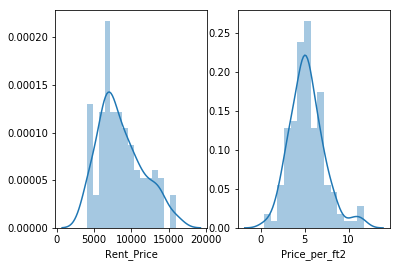

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2)
sns.distplot(ny_rent['Rent_Price'],bins=15, ax = ax[0])
sns.distplot(ny_rent['Price_per_ft2'],bins=15, ax = ax[1])
#fig.show()

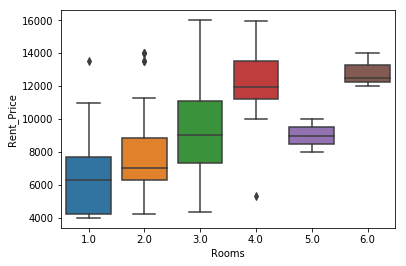

In [147]:
sns.boxplot(x='Rooms', y= 'Rent_Price', data=ny_rent)

In [155]:
# create map of Manhattan using latitude and longitude values from Nominatim
latitude= 40.7308619
longitude= -73.9871558

map_ny_rent = folium.Map(location=[latitude, longitude], zoom_start=12.5)

# add markers to map
for lat, lng, label in zip(ny_rent['Lat'], ny_rent['Long'],'$ ' + ny_rent['Rent_Price'].astype(str)+ ',  '+ ny_rent['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ny_rent) 
    

map_ny_rent

In [159]:
# create map of Manhattan using latitude and longitude values from Nominatim
latitude= 40.7308619
longitude= -73.9871558

# create map with clusters
kclusters=5
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_complete['Latitude'], ny_complete['Longitude'], ny_complete['Neighborhood'], ny_complete['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)

# add markers to map for rental places
for lat, lng, label in zip(ny_rent['Lat'], ny_rent['Long'],'$ ' + ny_rent['Rent_Price'].astype(str)+ ny_rent['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters2)  
    
     # Adds tool to the top right
from folium.plugins import MeasureControl
map_ny_rent.add_child(MeasureControl())

map_clusters2   

#### Conclusion: From the above map examination of apartments with rental place below 10000 is trival to select.